Testing hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64}


100%|████████████████████████████████████████| 170M/170M [00:04<00:00, 39.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64}: 69.95%
Testing hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 128}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 128}: 70.48%
Testing hyperparameters: {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_size': 64}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_size': 64}: 70.42%
Testing hyperparameters: {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_

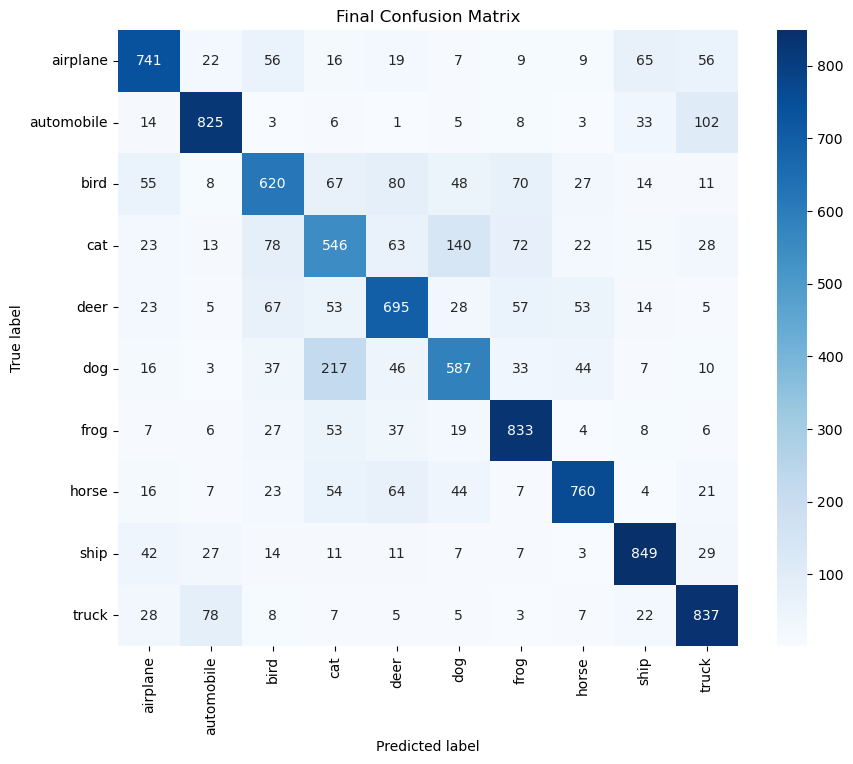

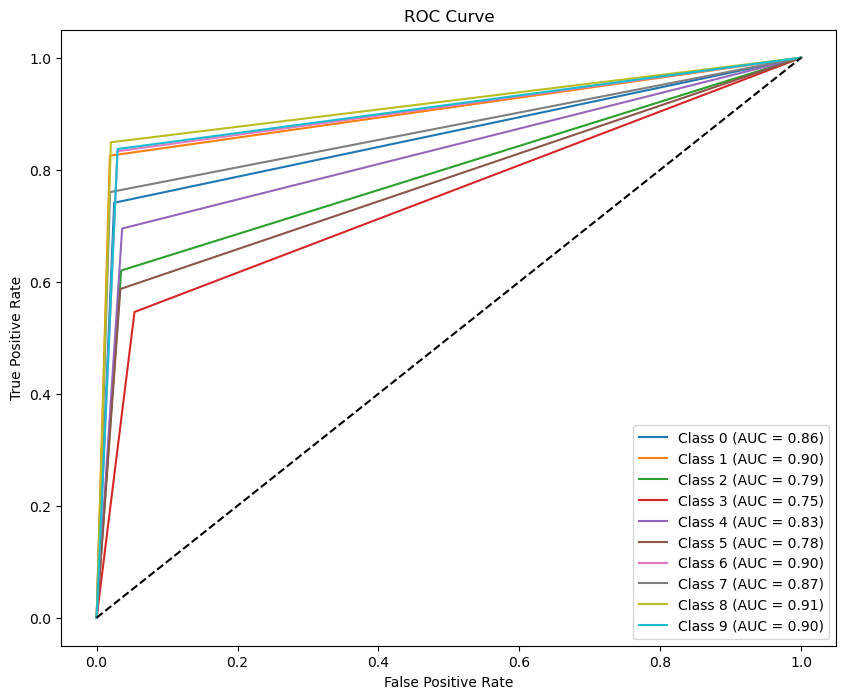

2024/12/07 19:43:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
from itertools import product
import seaborn as sns
import mlflow
import mlflow.pytorch

# Define CIFAR-10 label names
LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# CNN Model Definition
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Split dataset into training, validation, and test
def load_data_with_split(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    full_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

    # Train-validation split
    train_data, val_data, train_labels, val_labels = train_test_split(
        full_train_dataset.data, full_train_dataset.targets, test_size=0.2, stratify=full_train_dataset.targets, random_state=42
    )
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    val_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    train_dataset.data, train_dataset.targets = train_data, train_labels
    val_dataset.data, val_dataset.targets = val_data, val_labels

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Evaluation function for accuracy, F1 score, and loss
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return total_loss / len(data_loader), accuracy, f1, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(labels, predictions, num_classes=10):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(labels) == i, np.array(predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning
def hyperparameter_tuning(hyperparameter_space, device):
    best_hyperparams = None
    best_accuracy = 0

    for params in hyperparameter_space:
        print(f"Testing hyperparameters: {params}")
        train_loader, val_loader, _ = load_data_with_split(batch_size=params['batch_size'])
        model = CNNModel().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        # Training loop for validation accuracy
        for epoch in range(params['num_epochs']):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validation evaluation
        val_loss, val_acc, _, _, _ = evaluate_model(model, val_loader, criterion, device)
        print(f"Validation Accuracy for {params}: {val_acc:.2f}%")

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_hyperparams = params

    print(f"Best Hyperparameters: {best_hyperparams}, Best Validation Accuracy: {best_accuracy:.2f}%")
    return best_hyperparams

# Final training, validation, and testing with MLflow logging
def train_and_test_final_model(best_hyperparams, device):
    train_loader, val_loader, test_loader = load_data_with_split(best_hyperparams['batch_size'])
    full_train_loader = DataLoader(
        list(train_loader.dataset) + list(val_loader.dataset),
        batch_size=best_hyperparams['batch_size'],
        shuffle=True
    )
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['learning_rate'])

    with mlflow.start_run():
        mlflow.log_params(best_hyperparams)

        for epoch in range(best_hyperparams['num_epochs']):
            # Training phase
            model.train()
            total_train_loss = 0
            correct = 0
            total = 0
            for images, labels in full_train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
            train_acc = 100 * correct / total
            train_loss = total_train_loss / len(full_train_loader)

            # Validation and Testing phases
            val_loss, val_acc, val_f1, _, _ = evaluate_model(model, val_loader, criterion, device)
            test_loss, test_acc, test_f1, test_labels, test_predictions = evaluate_model(model, test_loader, criterion, device)

            # Log metrics
            mlflow.log_metrics({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_f1": val_f1,
                "test_loss": test_loss,
                "test_acc": test_acc,
                "test_f1": test_f1
            }, step=epoch)

            print(f"Epoch {epoch + 1}/{best_hyperparams['num_epochs']}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, F1 Score: {val_f1:.4f}")

        # Plot confusion matrix and ROC curve after training
        cm = confusion_matrix(test_labels, test_predictions)
        plot_confusion_matrix(cm, LABEL_NAMES, title="Final Confusion Matrix")
        plot_roc_curve(test_labels, test_predictions)

        # Log final model
        mlflow.pytorch.log_model(model, "cnn_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define hyperparameter space
    learning_rates = [0.001, 0.0005]
    num_epochs_list = [15]
    batch_sizes = [64, 128]
    hyperparameter_space = [
        {"learning_rate": lr, "num_epochs": ne, "batch_size": bs}
        for lr, ne, bs in product(learning_rates, num_epochs_list, batch_sizes)
    ]

    # Perform hyperparameter tuning
    best_hyperparams = hyperparameter_tuning(hyperparameter_space, device)

    # Train the final model with the best hyperparameters
    train_and_test_final_model(best_hyperparams, device)


Testing hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64}: 75.27%
Testing hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 128}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 128}: 75.41%
Testing hyperparameters: {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_size': 64}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_size': 64}: 75.08%
Tes

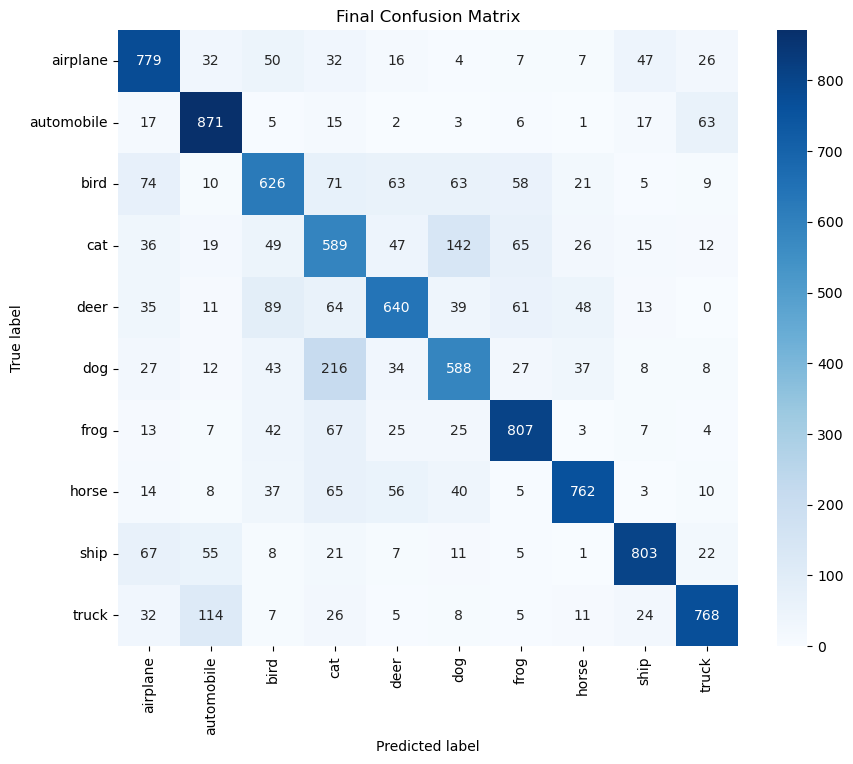

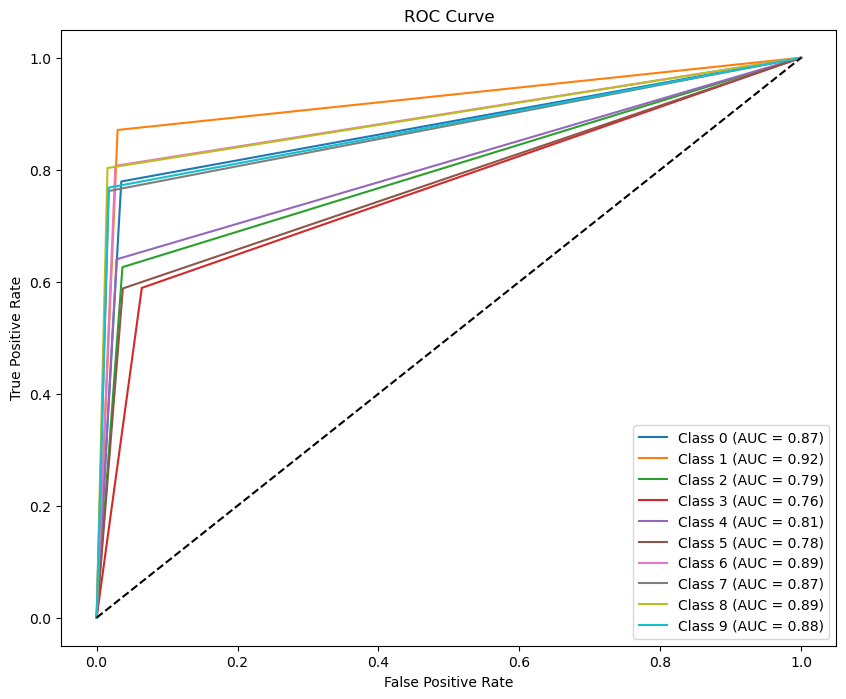

2024/12/07 20:28:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
from itertools import product
import seaborn as sns
import mlflow
import mlflow.pytorch

# Define CIFAR-10 label names
LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# CNN Model Definition
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Split dataset into training, validation, and test
def load_data_with_split(batch_size):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    full_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

    # Train-validation split
    train_data, val_data, train_labels, val_labels = train_test_split(
        full_train_dataset.data, full_train_dataset.targets, test_size=0.2, stratify=full_train_dataset.targets, random_state=42
    )
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    val_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    train_dataset.data, train_dataset.targets = train_data, train_labels
    val_dataset.data, val_dataset.targets = val_data, val_labels

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Evaluation function for accuracy, F1 score, and loss
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return total_loss / len(data_loader), accuracy, f1, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(labels, predictions, num_classes=10):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(labels) == i, np.array(predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning
def hyperparameter_tuning(hyperparameter_space, device):
    best_hyperparams = None
    best_accuracy = 0

    for params in hyperparameter_space:
        print(f"Testing hyperparameters: {params}")
        train_loader, val_loader, _ = load_data_with_split(batch_size=params['batch_size'])
        model = CNNModel().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        # Training loop for validation accuracy
        for epoch in range(params['num_epochs']):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validation evaluation
        val_loss, val_acc, _, _, _ = evaluate_model(model, val_loader, criterion, device)
        print(f"Validation Accuracy for {params}: {val_acc:.2f}%")

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_hyperparams = params

    print(f"Best Hyperparameters: {best_hyperparams}, Best Validation Accuracy: {best_accuracy:.2f}%")
    return best_hyperparams

# Final training, validation, and testing with MLflow logging
def train_and_test_final_model(best_hyperparams, device):
    train_loader, val_loader, test_loader = load_data_with_split(best_hyperparams['batch_size'])
    full_train_loader = DataLoader(
        list(train_loader.dataset) + list(val_loader.dataset),
        batch_size=best_hyperparams['batch_size'],
        shuffle=True
    )
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['learning_rate'])

    with mlflow.start_run():
        mlflow.log_params(best_hyperparams)

        for epoch in range(best_hyperparams['num_epochs']):
            # Training phase
            model.train()
            total_train_loss = 0
            correct = 0
            total = 0
            all_train_labels = []
            all_train_predictions = []
            for images, labels in full_train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                all_train_labels.extend(labels.cpu().numpy())
                all_train_predictions.extend(predicted.cpu().numpy())
            train_acc = 100 * correct / total
            train_loss = total_train_loss / len(full_train_loader)
            train_f1 = f1_score(all_train_labels, all_train_predictions, average='weighted')

            # Validation and Testing phases
            val_loss, val_acc, val_f1, _, _ = evaluate_model(model, val_loader, criterion, device)
            test_loss, test_acc, test_f1, test_labels, test_predictions = evaluate_model(model, test_loader, criterion, device)

            # Log metrics
            mlflow.log_metrics({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "train_f1": train_f1,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_f1": val_f1,
                "test_loss": test_loss,
                "test_acc": test_acc,
                "test_f1": test_f1
            }, step=epoch)

            print(f"Epoch {epoch + 1}/{best_hyperparams['num_epochs']}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, Test F1: {test_f1:.4f}")

        # Plot confusion matrix and ROC curve after training
        cm = confusion_matrix(test_labels, test_predictions)
        plot_confusion_matrix(cm, LABEL_NAMES, title="Final Confusion Matrix")
        plot_roc_curve(test_labels, test_predictions)

        # Log final model
        mlflow.pytorch.log_model(model, "cnn_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define hyperparameter space
    learning_rates = [0.001, 0.0005]
    num_epochs_list = [15]
    batch_sizes = [64, 128]
    hyperparameter_space = [
        {"learning_rate": lr, "num_epochs": ne, "batch_size": bs}
        for lr, ne, bs in product(learning_rates, num_epochs_list, batch_sizes)
    ]

    # Perform hyperparameter tuning
    best_hyperparams = hyperparameter_tuning(hyperparameter_space, device)

    # Train the final model with the best hyperparameters
    train_and_test_final_model(best_hyperparams, device)


Testing hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64}: 73.78%
Testing hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 128}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 128}: 74.19%
Testing hyperparameters: {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_size': 64}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_size': 64}: 74.24%
Tes

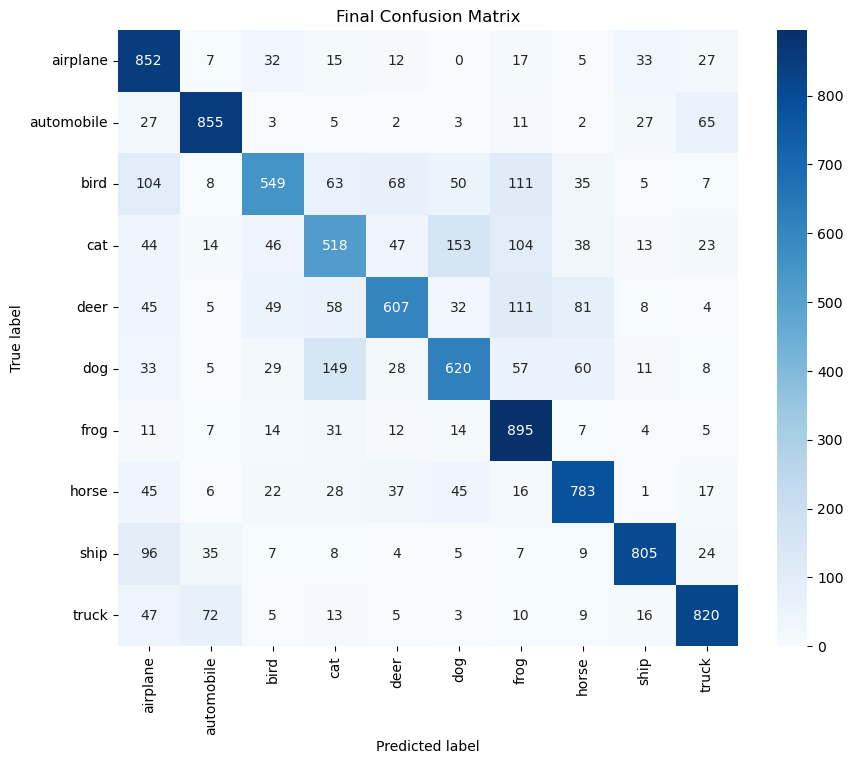

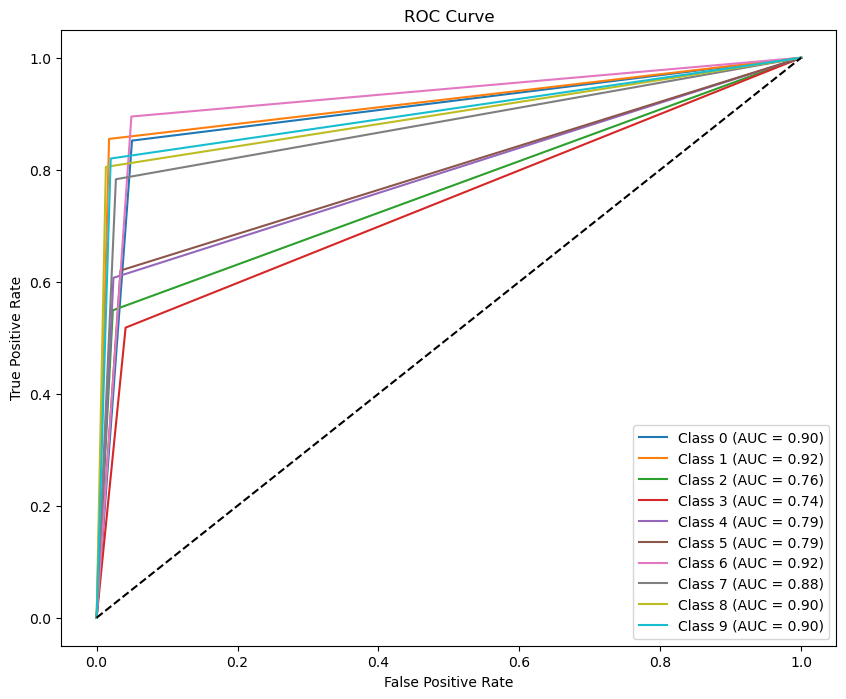

2024/12/07 21:10:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
from itertools import product
import seaborn as sns
import mlflow
import mlflow.pytorch

# Define CIFAR-10 label names
LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# CNN Model Definition
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Mixup function for data augmentation
def mixup_data(x, y, alpha=0.5):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Split dataset into training, validation, and test
def load_data_with_split(batch_size):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    full_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

    # Train-validation split
    train_data, val_data, train_labels, val_labels = train_test_split(
        full_train_dataset.data, full_train_dataset.targets, test_size=0.2, stratify=full_train_dataset.targets, random_state=42
    )
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    val_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    train_dataset.data, train_dataset.targets = train_data, train_labels
    val_dataset.data, val_dataset.targets = val_data, val_labels

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Evaluation function for accuracy, F1 score, and loss
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return total_loss / len(data_loader), accuracy, f1, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(labels, predictions, num_classes=10):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(labels) == i, np.array(predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning
def hyperparameter_tuning(hyperparameter_space, device):
    best_hyperparams = None
    best_accuracy = 0

    for params in hyperparameter_space:
        print(f"Testing hyperparameters: {params}")
        train_loader, val_loader, _ = load_data_with_split(batch_size=params['batch_size'])
        model = CNNModel().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        # Training loop for validation accuracy
        for epoch in range(params['num_epochs']):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validation evaluation
        val_loss, val_acc, _, _, _ = evaluate_model(model, val_loader, criterion, device)
        print(f"Validation Accuracy for {params}: {val_acc:.2f}%")

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_hyperparams = params

    print(f"Best Hyperparameters: {best_hyperparams}, Best Validation Accuracy: {best_accuracy:.2f}%")
    return best_hyperparams

# Final training, validation, and testing with MLflow logging
def train_and_test_final_model(best_hyperparams, device):
    train_loader, val_loader, test_loader = load_data_with_split(best_hyperparams['batch_size'])
    full_train_loader = DataLoader(
        list(train_loader.dataset) + list(val_loader.dataset),
        batch_size=best_hyperparams['batch_size'],
        shuffle=True
    )
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['learning_rate'])

    with mlflow.start_run():
        mlflow.log_params(best_hyperparams)

        for epoch in range(best_hyperparams['num_epochs']):
            # Training phase
            model.train()
            total_train_loss = 0
            correct = 0
            total = 0
            all_train_labels = []
            all_train_predictions = []
            for images, labels in full_train_loader:
                images, labels = images.to(device), labels.to(device)
                mixed_images, y_a, y_b, lam = mixup_data(images, labels, alpha=0.5)
                mixed_images = mixed_images.to(device)
                y_a, y_b = y_a.to(device), y_b.to(device)
                optimizer.zero_grad()
                outputs = model(mixed_images)
                loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (lam * (predicted == y_a).sum().item() + (1 - lam) * (predicted == y_b).sum().item())
                total += labels.size(0)
                all_train_labels.extend(labels.cpu().numpy())
                all_train_predictions.extend(predicted.cpu().numpy())
            train_acc = 100 * correct / total
            train_loss = total_train_loss / len(full_train_loader)
            train_f1 = f1_score(all_train_labels, all_train_predictions, average='weighted')

            # Validation and Testing phases
            val_loss, val_acc, val_f1, _, _ = evaluate_model(model, val_loader, criterion, device)
            test_loss, test_acc, test_f1, test_labels, test_predictions = evaluate_model(model, test_loader, criterion, device)

            # Log metrics
            mlflow.log_metrics({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "train_f1": train_f1,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_f1": val_f1,
                "test_loss": test_loss,
                "test_acc": test_acc,
                "test_f1": test_f1
            }, step=epoch)

            print(f"Epoch {epoch + 1}/{best_hyperparams['num_epochs']}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, Test F1: {test_f1:.4f}")

        # Plot confusion matrix and ROC curve after training
        cm = confusion_matrix(test_labels, test_predictions)
        plot_confusion_matrix(cm, LABEL_NAMES, title="Final Confusion Matrix")
        plot_roc_curve(test_labels, test_predictions)

        # Log final model
        mlflow.pytorch.log_model(model, "cnn_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define hyperparameter space
    learning_rates = [0.001, 0.0005]
    num_epochs_list = [15]
    batch_sizes = [64, 128]
    hyperparameter_space = [
        {"learning_rate": lr, "num_epochs": ne, "batch_size": bs}
        for lr, ne, bs in product(learning_rates, num_epochs_list, batch_sizes)
    ]

    # Perform hyperparameter tuning
    best_hyperparams = hyperparameter_tuning(hyperparameter_space, device)

    # Train the final model with the best hyperparameters
    train_and_test_final_model(best_hyperparams, device)


Testing hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64}: 69.94%
Testing hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 128}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 128}: 70.64%
Testing hyperparameters: {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_size': 64}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_size': 64}: 70.22%
Tes

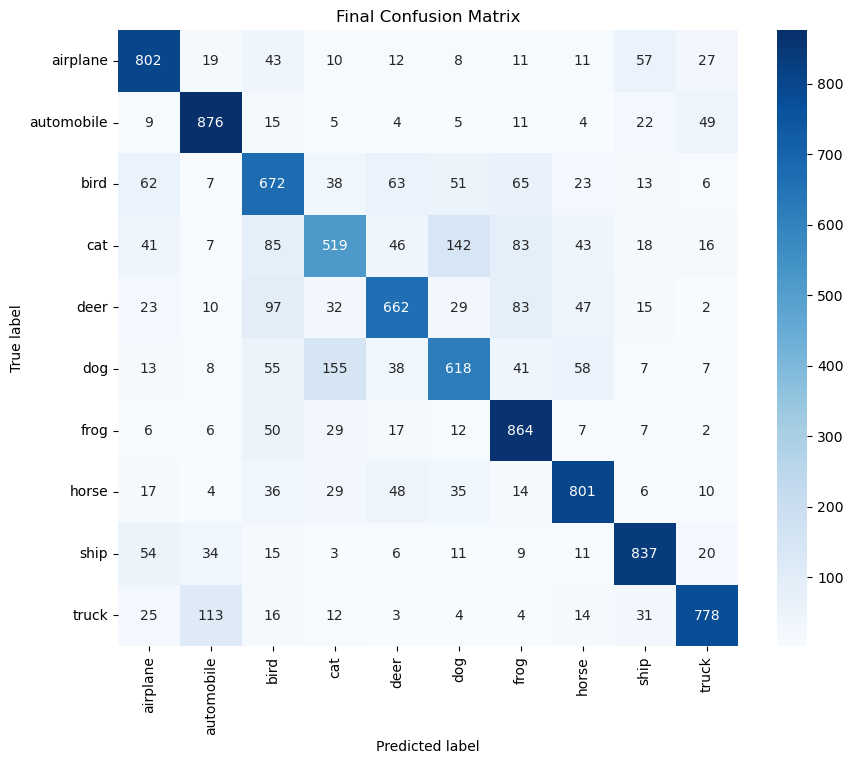

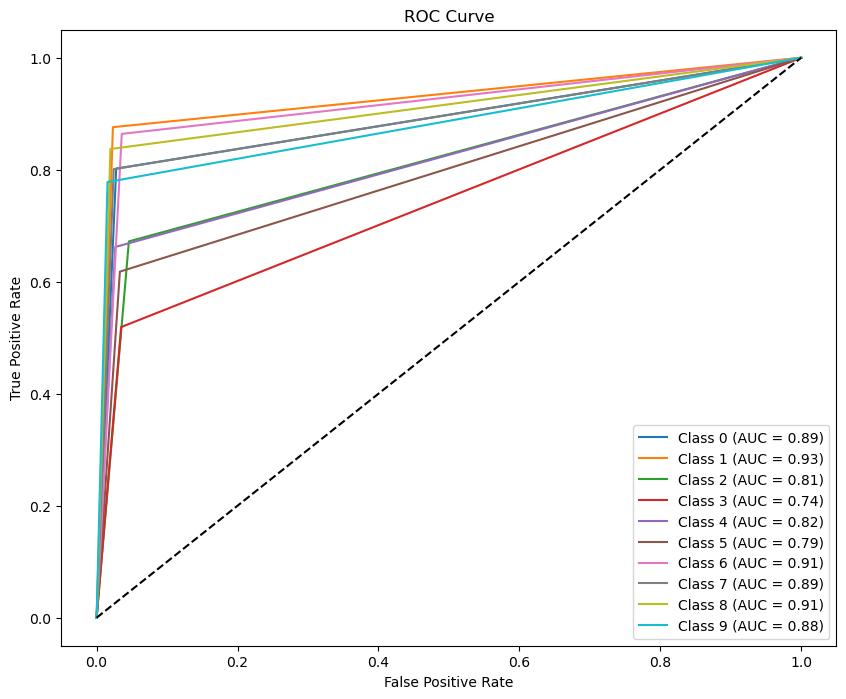

2024/12/07 21:49:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
from itertools import product
import seaborn as sns
import mlflow
import mlflow.pytorch

# Define CIFAR-10 label names
LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# CNN Model Definition
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Mixup function for data augmentation
def mixup_data(x, y, alpha=0.5):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Split dataset into training, validation, and test
def load_data_with_split(batch_size):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    full_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

    # Train-validation split
    train_data, val_data, train_labels, val_labels = train_test_split(
        full_train_dataset.data, full_train_dataset.targets, test_size=0.2, stratify=full_train_dataset.targets, random_state=42
    )
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    val_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    train_dataset.data, train_dataset.targets = train_data, train_labels
    val_dataset.data, val_dataset.targets = val_data, val_labels

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Evaluation function for accuracy, F1 score, and loss
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return total_loss / len(data_loader), accuracy, f1, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(labels, predictions, num_classes=10):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(labels) == i, np.array(predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning
def hyperparameter_tuning(hyperparameter_space, device):
    best_hyperparams = None
    best_accuracy = 0

    for params in hyperparameter_space:
        print(f"Testing hyperparameters: {params}")
        train_loader, val_loader, _ = load_data_with_split(batch_size=params['batch_size'])
        model = CNNModel().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        # Training loop for validation accuracy
        for epoch in range(params['num_epochs']):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validation evaluation
        val_loss, val_acc, _, _, _ = evaluate_model(model, val_loader, criterion, device)
        print(f"Validation Accuracy for {params}: {val_acc:.2f}%")

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_hyperparams = params

    print(f"Best Hyperparameters: {best_hyperparams}, Best Validation Accuracy: {best_accuracy:.2f}%")
    return best_hyperparams

# Final training, validation, and testing with MLflow logging
def train_and_test_final_model(best_hyperparams, device):
    train_loader, val_loader, test_loader = load_data_with_split(best_hyperparams['batch_size'])
    full_train_loader = DataLoader(
        list(train_loader.dataset) + list(val_loader.dataset),
        batch_size=best_hyperparams['batch_size'],
        shuffle=True
    )
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['learning_rate'])

    with mlflow.start_run():
        mlflow.log_params(best_hyperparams)

        for epoch in range(best_hyperparams['num_epochs']):
            # Training phase
            model.train()
            total_train_loss = 0
            correct = 0
            total = 0
            all_train_labels = []
            all_train_predictions = []
            for images, labels in full_train_loader:
                images, labels = images.to(device), labels.to(device)
                mixed_images, y_a, y_b, lam = mixup_data(images, labels, alpha=0.5)
                mixed_images = mixed_images.to(device)
                y_a, y_b = y_a.to(device), y_b.to(device)
                optimizer.zero_grad()
                outputs = model(mixed_images)
                loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (lam * (predicted == y_a).sum().item() + (1 - lam) * (predicted == y_b).sum().item())
                total += labels.size(0)
                all_train_labels.extend(labels.cpu().numpy())
                all_train_predictions.extend(predicted.cpu().numpy())
            train_acc = 100 * correct / total
            train_loss = total_train_loss / len(full_train_loader)
            train_f1 = f1_score(all_train_labels, all_train_predictions, average='weighted')

            # Validation and Testing phases
            val_loss, val_acc, val_f1, _, _ = evaluate_model(model, val_loader, criterion, device)
            test_loss, test_acc, test_f1, test_labels, test_predictions = evaluate_model(model, test_loader, criterion, device)

            # Log metrics
            mlflow.log_metrics({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "train_f1": train_f1,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_f1": val_f1,
                "test_loss": test_loss,
                "test_acc": test_acc,
                "test_f1": test_f1
            }, step=epoch)

            print(f"Epoch {epoch + 1}/{best_hyperparams['num_epochs']}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, Test F1: {test_f1:.4f}")

        # Plot confusion matrix and ROC curve after training
        cm = confusion_matrix(test_labels, test_predictions)
        plot_confusion_matrix(cm, LABEL_NAMES, title="Final Confusion Matrix")
        plot_roc_curve(test_labels, test_predictions)

        # Log final model
        mlflow.pytorch.log_model(model, "cnn_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define hyperparameter space
    learning_rates = [0.001, 0.0005]
    num_epochs_list = [15]
    batch_sizes = [64, 128]
    hyperparameter_space = [
        {"learning_rate": lr, "num_epochs": ne, "batch_size": bs}
        for lr, ne, bs in product(learning_rates, num_epochs_list, batch_sizes)
    ]

    # Perform hyperparameter tuning
    best_hyperparams = hyperparameter_tuning(hyperparameter_space, device)

    # Train the final model with the best hyperparameters
    train_and_test_final_model(best_hyperparams, device)


Testing hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64}: 69.97%
Testing hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 128}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 128}: 70.11%
Testing hyperparameters: {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_size': 64}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_size': 64}: 71.55%
Tes

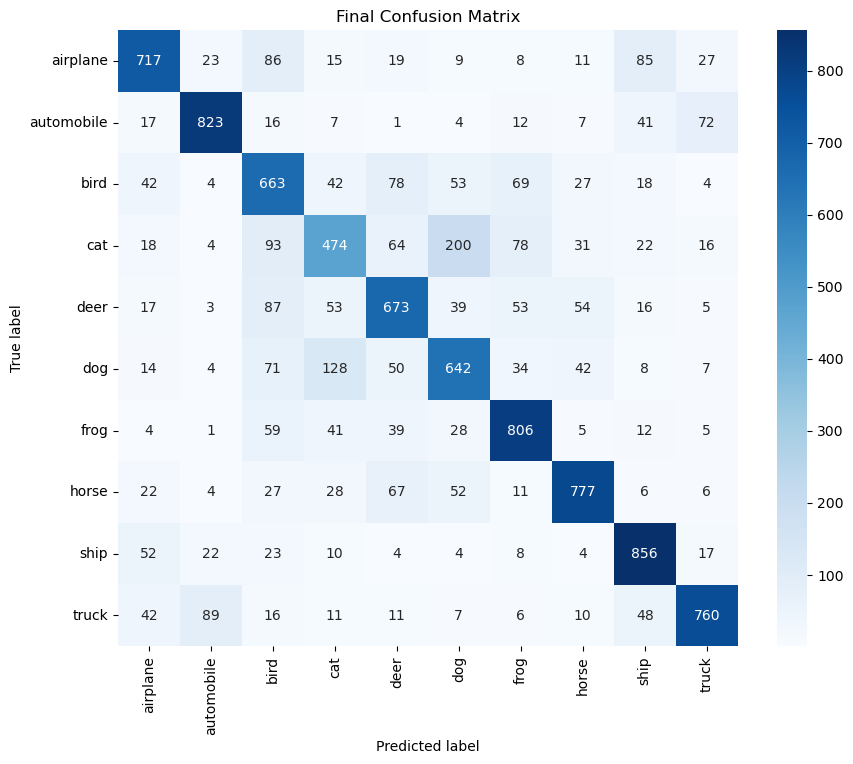

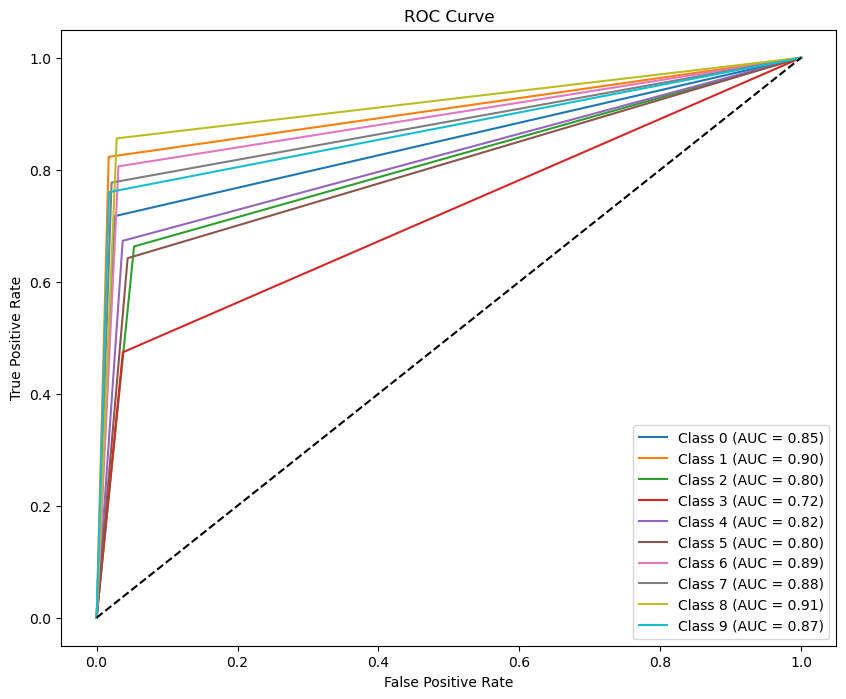

2024/12/07 22:30:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
from itertools import product
import seaborn as sns
import mlflow
import mlflow.pytorch

# Define CIFAR-10 label names
LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# CNN Model Definition
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Split dataset into training, validation, and test
def load_data_with_split(batch_size):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    full_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

    # Train-validation split
    train_data, val_data, train_labels, val_labels = train_test_split(
        full_train_dataset.data, full_train_dataset.targets, test_size=0.2, stratify=full_train_dataset.targets, random_state=42
    )
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    val_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    train_dataset.data, train_dataset.targets = train_data, train_labels
    val_dataset.data, val_dataset.targets = val_data, val_labels

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Evaluation function for accuracy, F1 score, and loss
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return total_loss / len(data_loader), accuracy, f1, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(labels, predictions, num_classes=10):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(labels) == i, np.array(predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning
def hyperparameter_tuning(hyperparameter_space, device):
    best_hyperparams = None
    best_accuracy = 0

    for params in hyperparameter_space:
        print(f"Testing hyperparameters: {params}")
        train_loader, val_loader, _ = load_data_with_split(batch_size=params['batch_size'])
        model = CNNModel().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        # Training loop for validation accuracy
        for epoch in range(params['num_epochs']):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validation evaluation
        val_loss, val_acc, _, _, _ = evaluate_model(model, val_loader, criterion, device)
        print(f"Validation Accuracy for {params}: {val_acc:.2f}%")

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_hyperparams = params

    print(f"Best Hyperparameters: {best_hyperparams}, Best Validation Accuracy: {best_accuracy:.2f}%")
    return best_hyperparams

# Final training, validation, and testing with MLflow logging
def train_and_test_final_model(best_hyperparams, device):
    train_loader, val_loader, test_loader = load_data_with_split(best_hyperparams['batch_size'])
    full_train_loader = DataLoader(
        list(train_loader.dataset) + list(val_loader.dataset),
        batch_size=best_hyperparams['batch_size'],
        shuffle=True
    )
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['learning_rate'])

    with mlflow.start_run():
        mlflow.log_params(best_hyperparams)

        for epoch in range(best_hyperparams['num_epochs']):
            # Training phase
            model.train()
            total_train_loss = 0
            correct = 0
            total = 0
            all_train_labels = []
            all_train_predictions = []
            for images, labels in full_train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                all_train_labels.extend(labels.cpu().numpy())
                all_train_predictions.extend(predicted.cpu().numpy())
            train_acc = 100 * correct / total
            train_loss = total_train_loss / len(full_train_loader)
            train_f1 = f1_score(all_train_labels, all_train_predictions, average='weighted')

            # Validation and Testing phases
            val_loss, val_acc, val_f1, _, _ = evaluate_model(model, val_loader, criterion, device)
            test_loss, test_acc, test_f1, test_labels, test_predictions = evaluate_model(model, test_loader, criterion, device)

            # Log metrics
            mlflow.log_metrics({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "train_f1": train_f1,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_f1": val_f1,
                "test_loss": test_loss,
                "test_acc": test_acc,
                "test_f1": test_f1
            }, step=epoch)

            print(f"Epoch {epoch + 1}/{best_hyperparams['num_epochs']}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, Test F1: {test_f1:.4f}")

        # Plot confusion matrix and ROC curve after training
        cm = confusion_matrix(test_labels, test_predictions)
        plot_confusion_matrix(cm, LABEL_NAMES, title="Final Confusion Matrix")
        plot_roc_curve(test_labels, test_predictions)

        # Log final model
        mlflow.pytorch.log_model(model, "cnn_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define hyperparameter space
    learning_rates = [0.001, 0.0005]
    num_epochs_list = [15]
    batch_sizes = [64, 128]
    hyperparameter_space = [
        {"learning_rate": lr, "num_epochs": ne, "batch_size": bs}
        for lr, ne, bs in product(learning_rates, num_epochs_list, batch_sizes)
    ]

    # Perform hyperparameter tuning
    best_hyperparams = hyperparameter_tuning(hyperparameter_space, device)

    # Train the final model with the best hyperparameters
    train_and_test_final_model(best_hyperparams, device)


Testing hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64}: 73.03%
Testing hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 128}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 128}: 74.13%
Testing hyperparameters: {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_size': 64}
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_size': 64}: 74.58%
Tes

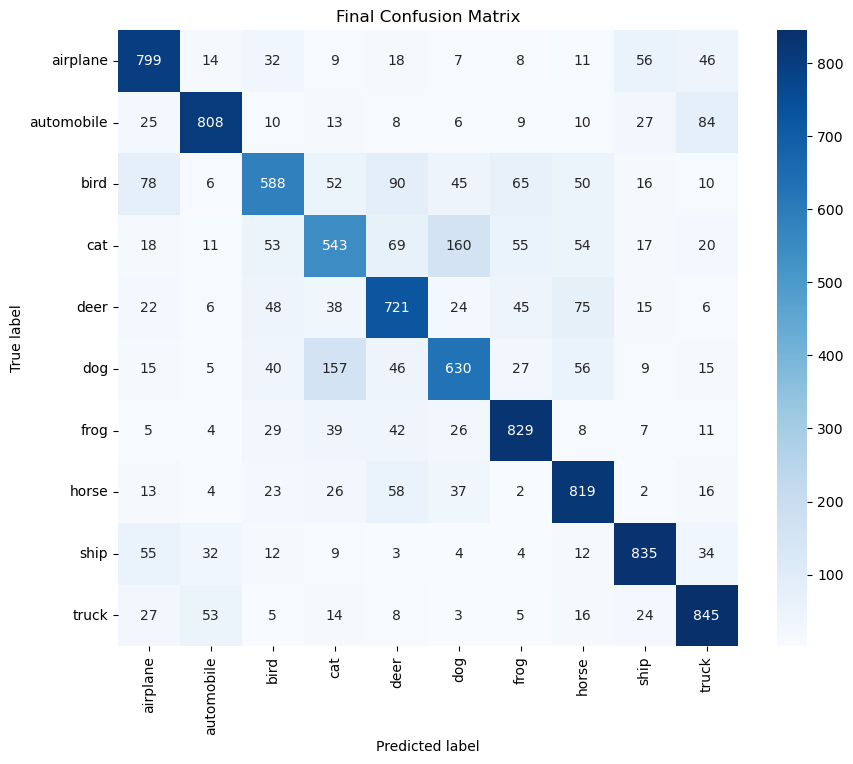

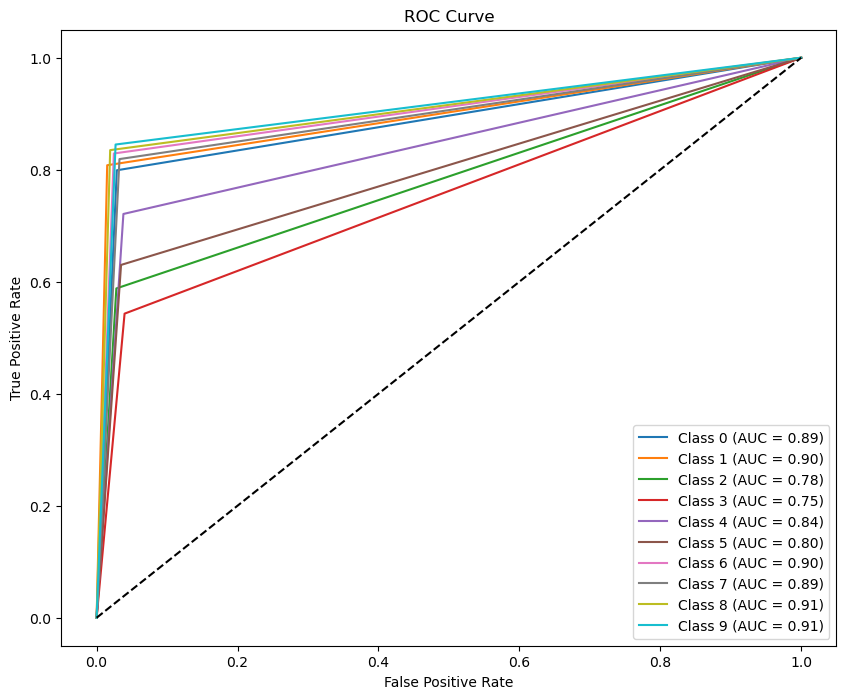

2024/12/07 23:08:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
from itertools import product
import seaborn as sns
import mlflow
import mlflow.pytorch

# Define CIFAR-10 label names
LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# CNN Model Definition
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Mixup function for data augmentation
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Split dataset into training, validation, and test
def load_data_with_split(batch_size):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    full_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

    # Train-validation split
    train_data, val_data, train_labels, val_labels = train_test_split(
        full_train_dataset.data, full_train_dataset.targets, test_size=0.2, stratify=full_train_dataset.targets, random_state=42
    )
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    val_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    train_dataset.data, train_dataset.targets = train_data, train_labels
    val_dataset.data, val_dataset.targets = val_data, val_labels

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Evaluation function for accuracy, F1 score, and loss
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return total_loss / len(data_loader), accuracy, f1, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(labels, predictions, num_classes=10):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(labels) == i, np.array(predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning
def hyperparameter_tuning(hyperparameter_space, device):
    best_hyperparams = None
    best_accuracy = 0

    for params in hyperparameter_space:
        print(f"Testing hyperparameters: {params}")
        train_loader, val_loader, _ = load_data_with_split(batch_size=params['batch_size'])
        model = CNNModel().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        # Training loop for validation accuracy
        for epoch in range(params['num_epochs']):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validation evaluation
        val_loss, val_acc, _, _, _ = evaluate_model(model, val_loader, criterion, device)
        print(f"Validation Accuracy for {params}: {val_acc:.2f}%")

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_hyperparams = params

    print(f"Best Hyperparameters: {best_hyperparams}, Best Validation Accuracy: {best_accuracy:.2f}%")
    return best_hyperparams

# Final training, validation, and testing with MLflow logging
def train_and_test_final_model(best_hyperparams, device):
    train_loader, val_loader, test_loader = load_data_with_split(best_hyperparams['batch_size'])
    full_train_loader = DataLoader(
        list(train_loader.dataset) + list(val_loader.dataset),
        batch_size=best_hyperparams['batch_size'],
        shuffle=True
    )
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['learning_rate'])

    with mlflow.start_run():
        mlflow.log_params(best_hyperparams)

        for epoch in range(best_hyperparams['num_epochs']):
            # Training phase
            model.train()
            total_train_loss = 0
            correct = 0
            total = 0
            all_train_labels = []
            all_train_predictions = []
            for images, labels in full_train_loader:
                images, labels = images.to(device), labels.to(device)
                mixed_images, y_a, y_b, lam = mixup_data(images, labels, alpha=0.5)
                mixed_images = mixed_images.to(device)
                y_a, y_b = y_a.to(device), y_b.to(device)
                optimizer.zero_grad()
                outputs = model(mixed_images)
                loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (lam * (predicted == y_a).sum().item() + (1 - lam) * (predicted == y_b).sum().item())
                total += labels.size(0)
                all_train_labels.extend(labels.cpu().numpy())
                all_train_predictions.extend(predicted.cpu().numpy())
            train_acc = 100 * correct / total
            train_loss = total_train_loss / len(full_train_loader)
            train_f1 = f1_score(all_train_labels, all_train_predictions, average='weighted')

            # Validation and Testing phases
            val_loss, val_acc, val_f1, _, _ = evaluate_model(model, val_loader, criterion, device)
            test_loss, test_acc, test_f1, test_labels, test_predictions = evaluate_model(model, test_loader, criterion, device)

            # Log metrics
            mlflow.log_metrics({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "train_f1": train_f1,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_f1": val_f1,
                "test_loss": test_loss,
                "test_acc": test_acc,
                "test_f1": test_f1
            }, step=epoch)

            print(f"Epoch {epoch + 1}/{best_hyperparams['num_epochs']}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, Test F1: {test_f1:.4f}")

        # Plot confusion matrix and ROC curve after training
        cm = confusion_matrix(test_labels, test_predictions)
        plot_confusion_matrix(cm, LABEL_NAMES, title="Final Confusion Matrix")
        plot_roc_curve(test_labels, test_predictions)

        # Log final model
        mlflow.pytorch.log_model(model, "cnn_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define hyperparameter space
    learning_rates = [0.001, 0.0005]
    num_epochs_list = [15]
    batch_sizes = [64, 128]
    hyperparameter_space = [
        {"learning_rate": lr, "num_epochs": ne, "batch_size": bs}
        for lr, ne, bs in product(learning_rates, num_epochs_list, batch_sizes)
    ]

    # Perform hyperparameter tuning
    best_hyperparams = hyperparameter_tuning(hyperparameter_space, device)

    # Train the final model with the best hyperparameters
    train_and_test_final_model(best_hyperparams, device)


Testing hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64}
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64}: 73.47%
Testing hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 128}
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 128}: 73.80%
Testing hyperparameters: {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_size': 64}
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_size': 64}: 74.03%
Testing hyperparameters: {'learning_rate': 0.0005, 'num_epochs': 15, 'batch_size': 128}
Files already downloaded and verified
Files already downloaded and verified
Validation Accuracy for {'learning_rate': 0.0005, 'num_epochs': 15,

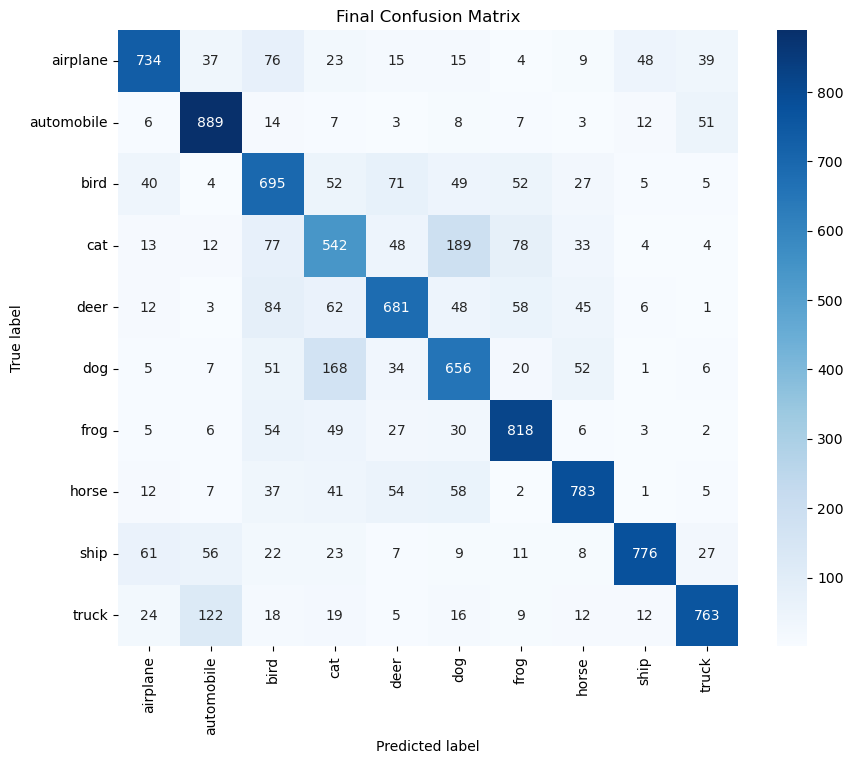

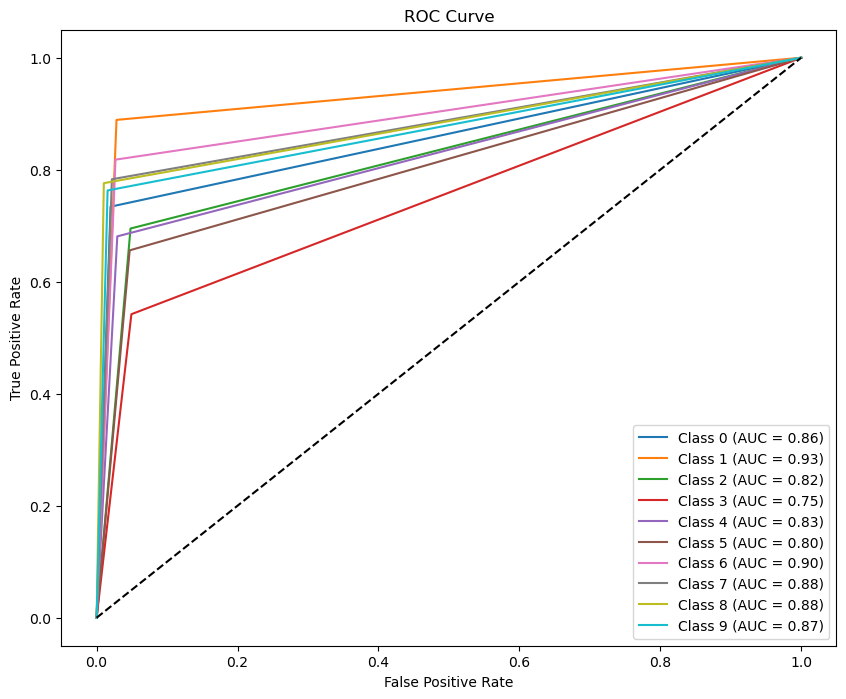

2024/12/08 11:41:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
from itertools import product
import seaborn as sns
from PIL import Image
import mlflow
import mlflow.pytorch

# Define CIFAR-10 label names
LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# CNN Model Definition
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Split dataset into training, validation, and test
def load_data_with_split(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    flip_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

    # Train-validation split
    train_data, val_data, train_labels, val_labels = train_test_split(
        full_train_dataset.data, full_train_dataset.targets, test_size=0.2, stratify=full_train_dataset.targets, random_state=42
    )

    # Augment training and validation datasets with flipped images
    def augment_dataset(data, labels, flip_transform):
        original_images = [transform(Image.fromarray(img)) for img in data]
        flipped_images = [flip_transform(Image.fromarray(img)) for img in data]
        combined_images = original_images + flipped_images
        combined_labels = labels + labels
        return combined_images, combined_labels

    train_images, train_labels = augment_dataset(train_data, train_labels, flip_transform)
    val_images, val_labels = augment_dataset(val_data, val_labels, flip_transform)

    train_dataset = [(img, label) for img, label in zip(train_images, train_labels)]
    val_dataset = [(img, label) for img, label in zip(val_images, val_labels)]
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Evaluation function for accuracy, F1 score, and loss
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return total_loss / len(data_loader), accuracy, f1, all_labels, all_predictions

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(labels, predictions, num_classes=10):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(labels) == i, np.array(predictions) == i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Hyperparameter tuning
def hyperparameter_tuning(hyperparameter_space, device):
    best_hyperparams = None
    best_accuracy = 0

    for params in hyperparameter_space:
        print(f"Testing hyperparameters: {params}")
        train_loader, val_loader, _ = load_data_with_split(batch_size=params['batch_size'])
        model = CNNModel().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        # Training loop for validation accuracy
        for epoch in range(params['num_epochs']):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validation evaluation
        val_loss, val_acc, _, _, _ = evaluate_model(model, val_loader, criterion, device)
        print(f"Validation Accuracy for {params}: {val_acc:.2f}%")

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_hyperparams = params

    print(f"Best Hyperparameters: {best_hyperparams}, Best Validation Accuracy: {best_accuracy:.2f}%")
    return best_hyperparams

# Final training, validation, and testing with MLflow logging
def train_and_test_final_model(best_hyperparams, device):
    train_loader, val_loader, test_loader = load_data_with_split(best_hyperparams['batch_size'])
    full_train_loader = DataLoader(
        list(train_loader.dataset) + list(val_loader.dataset),
        batch_size=best_hyperparams['batch_size'],
        shuffle=True
    )
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['learning_rate'])

    with mlflow.start_run():
        mlflow.log_params(best_hyperparams)

        for epoch in range(best_hyperparams['num_epochs']):
            # Training phase
            model.train()
            total_train_loss = 0
            correct = 0
            total = 0
            all_train_labels = []
            all_train_predictions = []
            for images, labels in full_train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                all_train_labels.extend(labels.cpu().numpy())
                all_train_predictions.extend(predicted.cpu().numpy())
            train_acc = 100 * correct / total
            train_loss = total_train_loss / len(full_train_loader)
            train_f1 = f1_score(all_train_labels, all_train_predictions, average='weighted')

            # Validation and Testing phases
            val_loss, val_acc, val_f1, _, _ = evaluate_model(model, val_loader, criterion, device)
            test_loss, test_acc, test_f1, test_labels, test_predictions = evaluate_model(model, test_loader, criterion, device)

            # Log metrics
            mlflow.log_metrics({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "train_f1": train_f1,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_f1": val_f1,
                "test_loss": test_loss,
                "test_acc": test_acc,
                "test_f1": test_f1
            }, step=epoch)

            print(f"Epoch {epoch + 1}/{best_hyperparams['num_epochs']}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, Test F1: {test_f1:.4f}")

        # Plot confusion matrix and ROC curve after training
        cm = confusion_matrix(test_labels, test_predictions)
        plot_confusion_matrix(cm, LABEL_NAMES, title="Final Confusion Matrix")
        plot_roc_curve(test_labels, test_predictions)

        # Log final model
        mlflow.pytorch.log_model(model, "cnn_model")
        print("Model logged in MLflow.")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define hyperparameter space
    learning_rates = [0.001, 0.0005]
    num_epochs_list = [15]
    batch_sizes = [64, 128]
    hyperparameter_space = [
        {"learning_rate": lr, "num_epochs": ne, "batch_size": bs}
        for lr, ne, bs in product(learning_rates, num_epochs_list, batch_sizes)
    ]

    # Perform hyperparameter tuning
    best_hyperparams = hyperparameter_tuning(hyperparameter_space, device)

    # Train the final model with the best hyperparameters
    train_and_test_final_model(best_hyperparams, device)


In [4]:
!mlflow ui --port 5000


[2024-12-08 12:32:18 -0500] [1229] [INFO] Starting gunicorn 23.0.0
[2024-12-08 12:32:18 -0500] [1229] [INFO] Listening at: http://127.0.0.1:5000 (1229)
[2024-12-08 12:32:18 -0500] [1229] [INFO] Using worker: sync
[2024-12-08 12:32:18 -0500] [1230] [INFO] Booting worker with pid: 1230
[2024-12-08 12:32:18 -0500] [1231] [INFO] Booting worker with pid: 1231
[2024-12-08 12:32:18 -0500] [1232] [INFO] Booting worker with pid: 1232
[2024-12-08 12:32:18 -0500] [1236] [INFO] Booting worker with pid: 1236
^C
[2024-12-08 12:34:03 -0500] [1229] [INFO] Handling signal: int
[2024-12-08 12:34:03 -0500] [1231] [INFO] Worker exiting (pid: 1231)
[2024-12-08 12:34:03 -0500] [1230] [INFO] Worker exiting (pid: 1230)
[2024-12-08 12:34:03 -0500] [1232] [INFO] Worker exiting (pid: 1232)
[2024-12-08 12:34:03 -0500] [1236] [INFO] Worker exiting (pid: 1236)


In [5]:
!mlflow ui


[2024-12-08 12:34:17 -0500] [1269] [INFO] Starting gunicorn 23.0.0
[2024-12-08 12:34:17 -0500] [1269] [INFO] Listening at: http://127.0.0.1:5000 (1269)
[2024-12-08 12:34:17 -0500] [1269] [INFO] Using worker: sync
[2024-12-08 12:34:17 -0500] [1270] [INFO] Booting worker with pid: 1270
[2024-12-08 12:34:17 -0500] [1271] [INFO] Booting worker with pid: 1271
[2024-12-08 12:34:17 -0500] [1272] [INFO] Booting worker with pid: 1272
[2024-12-08 12:34:17 -0500] [1273] [INFO] Booting worker with pid: 1273
^C
[2024-12-08 12:34:49 -0500] [1269] [INFO] Handling signal: int
[2024-12-08 12:34:49 -0500] [1273] [INFO] Worker exiting (pid: 1273)
[2024-12-08 12:34:49 -0500] [1271] [INFO] Worker exiting (pid: 1271)
[2024-12-08 12:34:49 -0500] [1270] [INFO] Worker exiting (pid: 1270)
[2024-12-08 12:34:49 -0500] [1272] [INFO] Worker exiting (pid: 1272)
